In [ ]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import matplotlib.font_manager as fm


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE

from konlpy.tag import Hannanum
from wordcloud import WordCloud
from collections import Counter
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from tqdm import tqdm


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 영화 다크나이트 리뷰 크롤링

# pre = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=62586&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=highest&page="
# review = []
# rate = []

# for i in range(1, 2720):
#     url = pre + str(i)
#     res = requests.get(url)

#     soup = BeautifulSoup(res.content,'html.parser')

#     id_list = []
#     id_pre = "_filtered_ment_"

#     for i in range(10):
#         id_list.append(id_pre+str(i))

#     for id in id_list:
#         review.append(soup.find("span", {"id":id}).get_text().strip())

#         rate_list = []
#         rate_list = (soup.select("div.star_score > em"))

    
#     for r in rate_list:
#         r = int(re.sub('<.+?>','',str(r)))
#         rate.append(r)

# df = pd.DataFrame({"review" : review, "rate" : rate})

# df = pd.DataFrame(df)
# df.to_csv("review_data.csv", header = False, index = False, encoding='utf-8-sig')

In [ ]:
!pip install konlpy wordcloud # konlpy, wordcloud 패키지 다운로드

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=fontpath)
fm._rebuild()

In [ ]:
df = pd.read_csv("다크나이트.csv", encoding="cp949")
df = pd.DataFrame({"review":df.iloc[:,0],
                   "rate":df.iloc[:, 1]}
    )
df['rate'] = np.where(df['rate']==10, 1, 0)
df.head()

,review,rate
0,그냥 말이 안됨... 다른 영화들과는 아예 급이나 수준이 차원이 다름. 보면서 내가...,1
1,다른 식상한 히어로물 필요없다 현실적이고 와닿는 배트맨,1
2,히스 레저가 별점 10점 중에 8점을 차지함,1
3,기립박수 또 박수 또 박수,1
4,속임수를 눈치챘지만 케이티홈즈에서 매기질렌할로 너프되자 망설임없이 하비덴트를 선택했...,1


In [ ]:
def text_edit(df):
    df["review"] = df["review"].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
    df["review"] = df["review"].str.replace('^ +', "")
    df["review"].replace('', np.nan, inplace=True)
    
    return df

In [ ]:
def extract(df):
    extractor = Hannanum()
    word_list = []
    for text in df['review']:
        word_list.extend(extractor.nouns(text))
    
    return word_list

In [ ]:
def count_word(word_list):
    count = Counter(word_list)
    words = dict(count.most_common())

    return words

In [ ]:
def preprocess(words):
    stop_words = ['영화', '감독', '배우', 'ㅋㅋ', 'ㅎㅎ', 'ㅠㅠ', '근데', '진짜', '배트맨', '조커', '재미', '평점']

    for word in list(words.keys()):
        if len(word) == 1:
            del words[word]
            continue
        if words[word] == 1:
            del words[word]

    for word in stop_words:
        if word in words.keys():
            del words[word]

    return words

In [ ]:
def word_cloud(words):
    words = dict(sorted(words.items(), key=lambda x : x[1], reverse=True)[:30])
    wordcloud = WordCloud(
        font_path = fontpath,
        width=2000,
        height=1000
    ).generate_from_frequencies(words)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
df = text_edit(df)
df = df.dropna()

df_positive = df[df["rate"] == 1]
df_negative = df[df["rate"] == 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


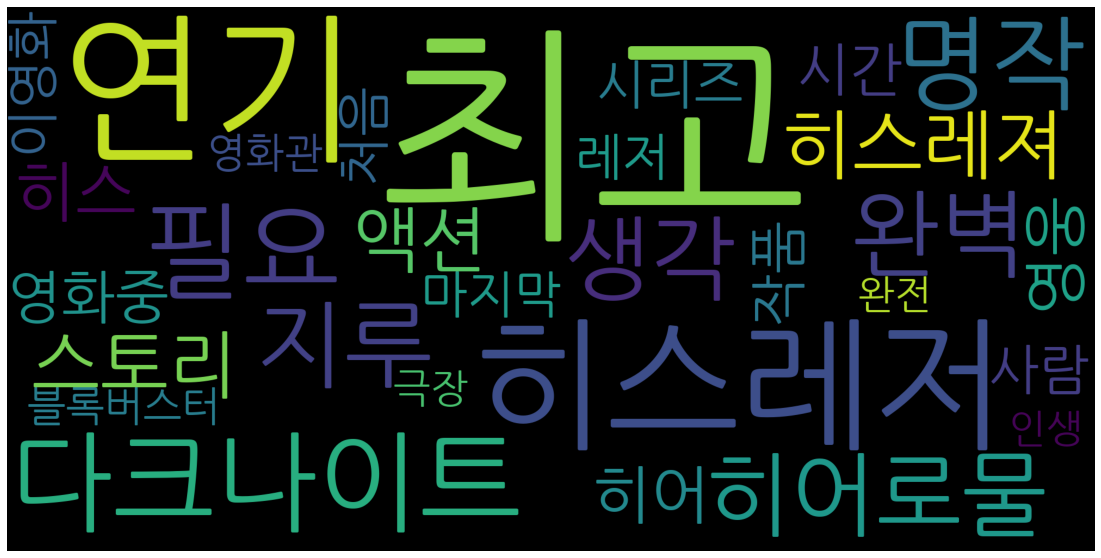

In [ ]:
word_list = extract(df)
words = count_word(word_list)
words = preprocess(words)
word_cloud(words)

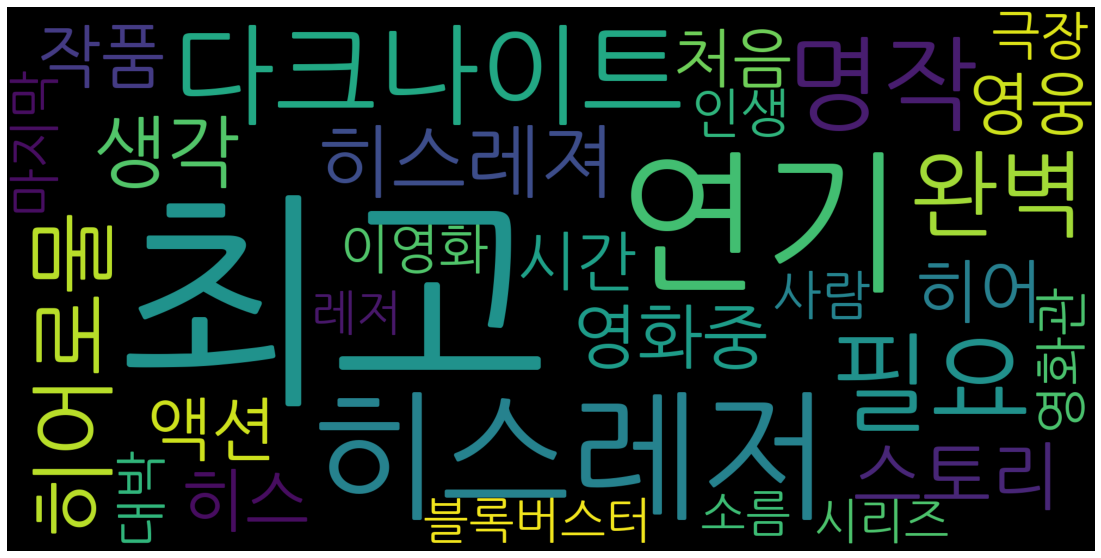

In [ ]:
word_list = extract(df_positive)
words = count_word(word_list)
words = preprocess(words)
word_cloud(words)

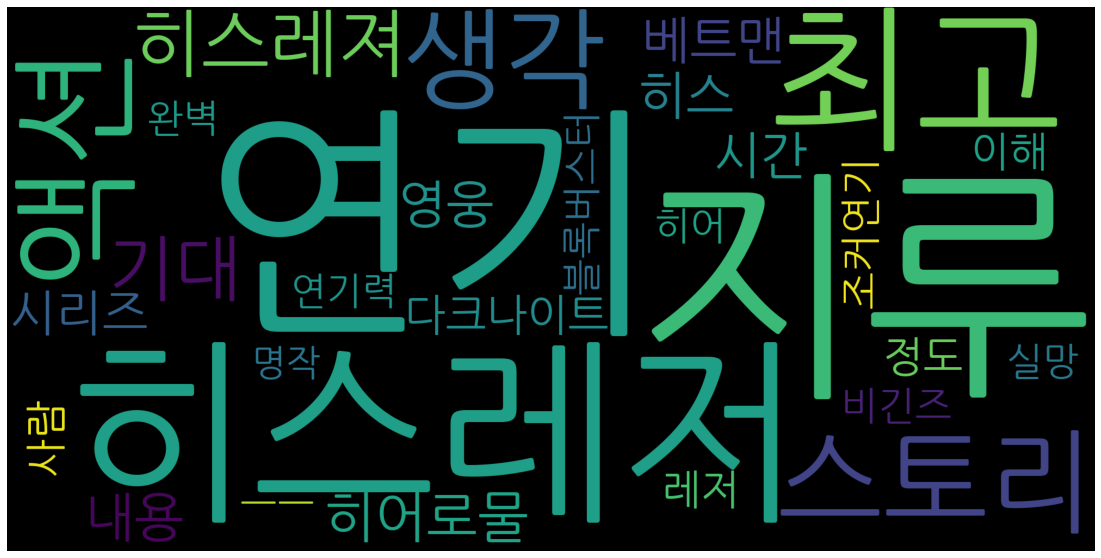

In [ ]:
word_list = extract(df_negative)
words = count_word(word_list)
words = preprocess(words)
word_cloud(words)

1    82.097676
0    17.902324
Name: rate, dtype: float64


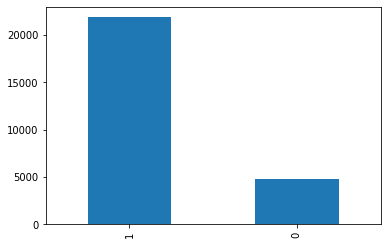

In [ ]:
print(df['rate'].value_counts()/len(df)*100)
df['rate'].value_counts().plot(kind='bar')

1    4770
0    4769
Name: rate, dtype: int64


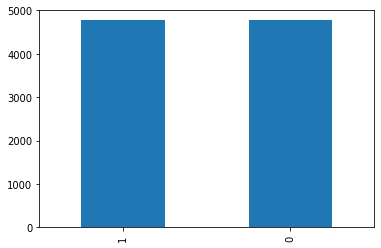

In [ ]:
def undersampling(df):
    nega_df = df[df['rate'] == 0]
    posi_df = df[df['rate'] == 1][:4770]

    new_df = pd.concat([nega_df, posi_df])
    print(new_df['rate'].value_counts())
    new_df['rate'].value_counts().plot(kind='bar')


    return new_df

new_df = undersampling(df)

In [ ]:
with open("한국어불용어100.txt") as f:
    text = f.read()
    text = re.compile('[가-힣]+').findall(text)
    print(text)

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = stopwords + text

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [ ]:
def tokenize(df):
    okt = Okt()
    X = []
    for sentence in tqdm(df['review']):
        tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X.append(stopwords_removed_sentence)

    return X

X = tokenize(df)
X_undersampling = tokenize(new_df)

100%|██████████| 9539/9539 [00:21<00:00, 438.35it/s]


In [ ]:
def transform(X):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    return tokenizer

tokenizer = transform(X)
tokenizer_undersampling = transform(X_undersampling)

In [ ]:
def vocab_size(tokenizer, threshold):
    threshold = threshold
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    vocab_size = total_cnt - rare_cnt + 1

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print('단어 집합의 크기 :',vocab_size)
    

    return vocab_size

vocab_size_X = vocab_size(tokenizer, threshold=3)
print()
print("-"*60)
print()
vocab_size_undersampled_X = vocab_size(tokenizer_undersampling, threshold=3)

단어 집합(vocabulary)의 크기 : 10210
등장 빈도가 2번 이하인 희귀 단어의 수: 6070
단어 집합에서 희귀 단어의 비율: 59.4515181194907
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5361853883502095
단어 집합의 크기 : 4141

------------------------------------------------------------

단어 집합(vocabulary)의 크기 : 7273
등장 빈도가 2번 이하인 희귀 단어의 수: 4543
단어 집합에서 희귀 단어의 비율: 62.463907603464875
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.362247067069597
단어 집합의 크기 : 2731


In [ ]:
def text_to_sequences(df, vocab_size, X):
    tokenizer = Tokenizer(vocab_size) 
    tokenizer.fit_on_texts(X)
    X_train = tokenizer.texts_to_sequences(X)
    y_train = np.array(df['rate'])

    drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
    X_train = np.delete(X_train, drop_train, axis=0)
    y_train = np.delete(y_train, drop_train, axis=0)
    print(len(X_train))
    print(len(y_train))

    return X_train, y_train, tokenizer


X_train, y_train, tokenizer = text_to_sequences(df, vocab_size_X, X)
X_train_under, y_train_under, tokenizer_undersampling = text_to_sequences(new_df, vocab_size_undersampled_X, X_undersampling)

26566
26566
9513
9513


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 40
리뷰의 평균 길이 : 7.605811940073779


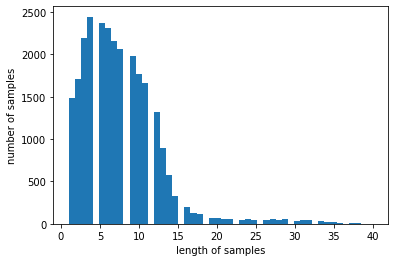


리뷰의 최대 길이 : 40
리뷰의 평균 길이 : 8.56638284452854


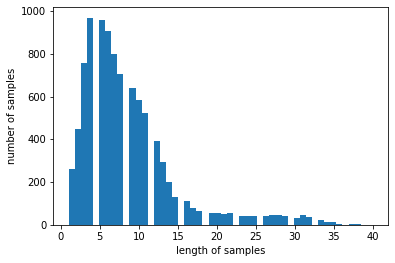

In [ ]:
def length_review(X_train):
    print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
    print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
    plt.hist([len(review) for review in X_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

length_review(X_train)
print()
length_review(X_train_under)

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


below_threshold_len(25, X_train)
below_threshold_len(30, X_train_under)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 98.3851539561846
전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.52832965415746


In [ ]:
X_train = pad_sequences(X_train, maxlen=25)
X_train_under = pad_sequences(X_train_under, maxlen=30)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=101)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_train_under, y_train_under, test_size=0.3, random_state=101)

X_train.shape, y_train.shape, X_train_under.shape, y_train_under.shape

((18596, 25), (18596,), (6659, 30), (6659,))

In [ ]:
def modeling(X, y, vocab_size):
    embedding_dim = 100
    hidden_units = 128

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dense(1, activation='sigmoid'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X, y, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

    return model

model = modeling(X_train, y_train, vocab_size_X)
print()
print()
print()
undersampled_model = modeling(X_train_under, y_train_under, vocab_size_undersampled_X)

Epoch 1/15
232/233 [============================>.] - ETA: 0s - loss: 0.4007 - acc: 0.8354
Epoch 1: val_acc improved from -inf to 0.86613, saving model to best_model.h5
233/233 [==============================] - 24s 82ms/step - loss: 0.4003 - acc: 0.8356 - val_loss: 0.3537 - val_acc: 0.8661
Epoch 2/15
232/233 [============================>.] - ETA: 0s - loss: 0.3238 - acc: 0.8713
Epoch 2: val_acc did not improve from 0.86613
233/233 [==============================] - 17s 74ms/step - loss: 0.3235 - acc: 0.8715 - val_loss: 0.3617 - val_acc: 0.8648
Epoch 3/15
232/233 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.8814
Epoch 3: val_acc improved from 0.86613 to 0.87554, saving model to best_model.h5
233/233 [==============================] - 17s 73ms/step - loss: 0.3013 - acc: 0.8814 - val_loss: 0.3346 - val_acc: 0.8755
Epoch 4/15
232/233 [============================>.] - ETA: 0s - loss: 0.2873 - acc: 0.8878
Epoch 4: val_acc did not improve from 0.87554
233/233 [=======

In [ ]:
def model_eval(model, X_t, y_t):
    y_pred = model.predict(X_t)
    y_pred = np.where(y_pred > 0.6, 1, 0)

    print(confusion_matrix(y_t, y_pred))
    print(accuracy_score(y_t, y_pred))
    print(classification_report(y_t, y_pred))

    precision = confusion_matrix(y_t, y_pred)[0][0]/(confusion_matrix(y_t, y_pred)[0][0]+confusion_matrix(y_t, y_pred)[1][0])
    recall = confusion_matrix(y_t, y_pred)[0][0]/(confusion_matrix(y_t, y_pred)[0][0]+confusion_matrix(y_t, y_pred)[0][1])
    f1_sco = 2 * ((precision * recall) / (precision + recall))

    print("F1-Score : ", f1_sco)

model_eval(model, X_test,y_test)
print("-"*60)
model_eval(undersampled_model, X_test_under, y_test_under)

[[ 794  609]
 [ 625 5942]]
0.8451693851944793
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      1403
           1       0.91      0.90      0.91      6567

    accuracy                           0.85      7970
   macro avg       0.73      0.74      0.73      7970
weighted avg       0.85      0.85      0.85      7970

F1-Score :  0.5627214741318214
------------------------------------------------------------
[[1208  239]
 [ 344 1063]]
0.7957252978276104
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1447
           1       0.82      0.76      0.78      1407

    accuracy                           0.80      2854
   macro avg       0.80      0.80      0.80      2854
weighted avg       0.80      0.80      0.80      2854

F1-Score :  0.8056018672890963


In [ ]:
def sentiment_predict(new_sentence, tokenizer, max_len):
    okt = Okt()
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.6):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('아 진짜 지루하다', tokenizer, 25)
sentiment_predict('아 진짜 지루하다', tokenizer_undersampling, 30)

63.70% 확률로 부정 리뷰입니다.

88.60% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ', tokenizer, 25)
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ', tokenizer_undersampling, 30)

79.31% 확률로 긍정 리뷰입니다.

68.80% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('평점 믿고 봤는데 지루하다', tokenizer, 25)
sentiment_predict('평점 믿고 봤는데 지루하다', tokenizer_undersampling, 30)

54.37% 확률로 부정 리뷰입니다.

98.55% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('킬링타임용 영화', tokenizer, 25)
sentiment_predict('킬링타임용 영화', tokenizer_undersampling, 30)

72.41% 확률로 긍정 리뷰입니다.

82.86% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?', tokenizer, 25)
sentiment_predict('감독 뭐하는 놈이냐?', tokenizer_undersampling, 30)

81.03% 확률로 부정 리뷰입니다.

45.31% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다', tokenizer, 25)
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다', tokenizer_undersampling, 30)

76.96% 확률로 부정 리뷰입니다.

96.12% 확률로 긍정 리뷰입니다.

